In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from datetime import datetime, timedelta
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import f1_score

In [79]:
# Lines added to make dataframes with large number of columns get displayed in their entirety
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
extension = "../datasets"

In [80]:
df = pd.read_csv(extension + '/alerts_data.csv', index_col=False)
df = df[df['alert_repository'].isin(['autoland', 'mozilla-beta'])]

df['alert_push_timestamp'] = pd.to_datetime(df['alert_push_timestamp'], unit='s')

<ipython-input-80-3b3f01935ef4>:1: DtypeWarning: Columns (24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(extension + '/alerts_data.csv', index_col=False)


In [81]:
display(df.head(5))

,alert_id,alert_push_id,alert_prev_push_id,alert_creation_timestamp,alert_first_triaged,alert_triage_due_date,alert_repository,alert_framework,test_id,test_status,test_series_signature_id,test_series_signature_framework_id,test_series_signature_signature_hash,test_series_signature_machine_platform,test_series_signature_test,test_series_signature_suite,test_series_signature_lower_is_better,test_series_signature_has_subtests,test_series_signature_option_collection_hash,test_series_signature_tags,test_series_signature_extra_options,test_series_signature_measurement_unit,test_series_signature_suite_public_name,test_series_signature_test_public_name,test_prev_taskcluster_metadata_task_id,test_prev_taskcluster_metadata_retry_id,test_taskcluster_metadata_task_id,test_taskcluster_metadata_retry_id,test_profile_url,test_prev_profile_url,test_is_regression,test_prev_value,test_new_value,test_t_value,test_amount_abs,test_amount_pct,test_summary_id,test_related_summary_id,test_manually_created,test_classifier,test_starred,test_classifier_email,test_backfill_record_context,test_backfill_record_status,test_backfill_record_total_actions_triggered,test_backfill_record_total_backfills_failed,test_backfill_record_total_backfills_successful,test_backfill_record_total_backfills_in_progress,test_noise_profile,alert_related_alerts,alert_status,alert_bug_number,alert_bug_due_date,alert_bug_updated,alert_issue_tracker,alert_notes,alert_revision,alert_push_timestamp,alert_prev_push_revision,alert_assignee_username,alert_assignee_email,alert_performance_tags
0,139,1423417,1423368,2024-05-08T17:54:23.264764,NaN,2024-05-13T17:54:23.264764,autoland,6,496,0,4662919,6,2886a3d67e6faeb4aa8d2d13860caae4a5ab1a4d,windows11-32-2009-qr,PerfStripCharsCRLF,Strings,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,NaN,NaN,NaN,NaN,QP7M4A4lQ1y93AQ514z7LQ,0.0,ILQOT39SQomPqLe2F5StxQ,0.0,NaN,NaN,False,333164.25,223024.17,15.04,-110140.08,33.06,139,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OUTLIERS,NaN,0,NaN,2024-05-15T17:54:23.264764,NaN,1,NaN,ed7b6f65910afcd687ef5aaa25605666805796bb,2024-05-08 13:09:13,2dc2a910325211c4136365c9647e990a7c7dd22e,NaN,NaN,NaN
1,138,1423277,1423269,2024-05-08T17:24:58.063351,NaN,2024-05-13T17:24:58.063351,autoland,6,495,0,3482492,6,3f826ce9164041044ad62bd80940c584561f1a19,macosx1015-64-qr,PerfUTF8toUTF16KOThousand,Strings,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,NaN,NaN,NaN,NaN,DxpIrvXPSFKeXX8cvej11g,0.0,ConJc8EPTqmV-Kg92P3Otg,0.0,NaN,NaN,True,176813.12,212071.75,7.91,35258.62,19.94,138,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SKEWED,NaN,0,NaN,2024-05-15T17:24:58.063351,NaN,1,NaN,a5478f44911c8f8908f09e2fbc4d728c0d170497,2024-05-08 06:09:03,a0b3e2669a2dc49c467521cb9b7966ca05e3dbc3,NaN,NaN,NaN
2,137,1423124,1423077,2024-05-08T16:31:27.262251,NaN,2024-05-13T16:31:27.262251,autoland,6,493,0,3482392,6,77060156e1ae922a978c99ce35068106eb40749e,macosx1015-64-qr,PerfIsUTF8Hundred,Strings,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,NaN,NaN,NaN,NaN,e7Bev2E0S4SHmsXqEeid0A,0.0,JA8lSVK3RfWm_wia5nizNA,0.0,NaN,NaN,True,2821.71,3527.08,9.52,705.38,25.00,137,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OUTLIERS,NaN,0,NaN,2024-05-15T16:31:27.262251,NaN,1,NaN,149e752fdb3fa75a3a02f55e7c7c91f7f704cf8a,2024-05-07 22:14:58,a2d3990d919176afe79ac26a0f781f1721c823e1,NaN,NaN,NaN
3,137,1423124,1423077,2024-05-08T16:31:27.262251,NaN,2024-05-13T16:31:27.262251,autoland,6,494,0,4662915,6,2606d85e165765a20f96a4e2f1d8b2990a4c721a,windows11-32-2009-qr,PerfStripWhitespace,Strings,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,NaN,NaN,NaN,NaN,UpAqMUYBTtSnbXnhlOD-xw,0.0,PTJKykhaSO-Vu8mmyTMyrg,0.0,NaN,NaN,False,69291.08,52940.00,7.66,-16351.08,23.60,137,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SKEWED,NaN,0,NaN,2024-05-15T16:31:27.262251,NaN,1,NaN,149e752fdb3fa75a3a02f55e7c7c91f7f704cf8a,2024-05-07 22:14:58,a2d3990d919176afe79ac26a0f781f1721c823e1,NaN,NaN,NaN
4,136,1421812,1421623,2024-05-08T16:20:10.262939,NaN,2024-05

In [82]:
# the mapping was concluded by comparing data from the dataset with data on Perfherder
alert_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "improvement",
    5: "investigating",
    6: "wontfix",
    7: "fixed",
    8: "backedout"
}
# the framwork mapping was taken from the following API endpiint's response : https://treeherder.mozilla.org/docs/#tag/api/operation/listPerformanceFrameworks
framework_mapping = {
    1: "talos",
    2: "build_metrics",
    4: "awsy",
    6: "platform_microbench",
    10: "raptor",
    11: "js-bench",
    12: "devtools",
    13: "browsertime",
    15: "mozperftest",
    16: "fxrecord"
}
# the mapping was concluded by comparing data from the dataset with data on Perfherder
test_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "acknowledged"
}

In [83]:
df['alert_framework'] = df['alert_framework'].map(framework_mapping)
df['alert_status'] = df['alert_status'].map(alert_status_mapping)
df['test_status'] = df['test_status'].map(test_status_mapping)

In [84]:
alerts_df = df.filter(like='alert_').drop_duplicates()

In [85]:
category_to_find = 'speedometer3'
total_rows = len(alerts_df)
speedometer3_df = df[df['test_series_signature_suite'] == category_to_find]
speedometer3_signature_count = speedometer3_df["alert_id"].nunique()
percentage = (speedometer3_signature_count / total_rows) * 100
print(f"Percentage of alerts associated with Speedometer3 test suite : {percentage:.2f}%")

Percentage of alerts associated with Speedometer3 test suite : 1.59%


the following commented out code was used initially to identify TP6 tests as it was believed that TP6 tests are identified via the "TP6" label in the "Tags & Options" column [here](https://treeherder.mozilla.org/perfherder/alerts?hideDwnToInv=1&page=1). This assumption was debunked by Mozilla performance engineering team

In [86]:
'''category_to_find = 'tp6'
tp6_df = df[df['test_series_signature_extra_options'].str.contains(category_to_find, na=False)]
percentage = (tp6_df['alert_id'].nunique() / total_rows) * 100
print(f"Percentage of alerts associated with TP6 test suite : {percentage:.2f}%")'''

'category_to_find = \'tp6\'\ntp6_df = df[df[\'test_series_signature_extra_options\'].str.contains(category_to_find, na=False)]\npercentage = (tp6_df[\'alert_id\'].nunique() / total_rows) * 100\nprint(f"Percentage of alerts associated with TP6 test suite : {percentage:.2f}%")'

The selection criteria for filtering out aerts related to TP6 according to Mozilla performance engineering team is that all test suites from [here](https://firefox-source-docs.mozilla.org/testing/perfdocs/raptor.html#desktop) or [here](https://firefox-source-docs.mozilla.org/testing/perfdocs/raptor.html#mobile) are considered under the umbrella of TP6.

In [87]:
desktop_list = ["amazon", "bing-search", "buzzfeed", "cnn", "docomo", "ebay", "espn", "expedia", "facebook", "fandom", "google-docs", "google-mail", "google-search", "google-slides", "imdb", "imgue", "instagram", "linkedin", "microsoft", "netflix", "nytimes", "office", "openai", "outlook", "paypal", "pinterest", "reddit", "samsung", "tiktok", "tumblr", "twitch", "twitter", "weather", "wikia", "wikipedia", "yahoo-mail", "youtube"]
mobile_list = ["allrecipes", "amazon", "amazon-search", "bild-de", "bing", "bing-search-restaurants", "booking", "cnn", "cnn-ampstories", "dailymail", "ebay-kleinanzeigen", "ebay-kleinanzeigen-search", "espn", "facebook", "facebook-cristiano", "google", "google-maps", "google-search-restaurants", "imdb", "instagram", "microsoft-support", "reddit", "sina", "stackoverflow", "wikipedia", "youtube", "youtube-watch"]
tp6_suites_list = list(set(desktop_list + mobile_list))
tp6_df = df[df['test_series_signature_suite'].isin(tp6_suites_list)]
percentage = (tp6_df['alert_id'].nunique() / total_rows) * 100
print(f"Percentage of alerts associated with TP6 test suite : {percentage:.2f}%")

Percentage of alerts associated with TP6 test suite : 36.58%


In [88]:
def display_xp(dataf, tp):
  lst = []
  if tp:
    lst = ["backedout", "fixed", "improvement", "wontfix", "reassigned"]
  else:
    lst = ["invalid"]
  filtered_df = dataf[dataf['alert_status'].isin(lst)]
  sig_counts = filtered_df['test_series_signature_id'].value_counts()
  top_sig = sig_counts.nlargest(4).index
  result_df = filtered_df[filtered_df['test_series_signature_id'].isin(top_sig)]
  print(result_df["test_series_signature_id"].value_counts())

In [89]:
print("top 3 signature IDs associated with true positive alerts in the speedometer3 category")
display_xp(speedometer3_df, True)
print("top 3 signature IDs associated with false positive alerts in the speedometer3 category")
display_xp(speedometer3_df, False)
print("top 3 signature IDs associated with true positive alerts in the TP6 category")
display_xp(tp6_df, True)
print("top 3 signature IDs associated with false positive alerts in the TP6 category")
display_xp(tp6_df, False)

top 3 signature IDs associated with true positive alerts in the speedometer3 category
test_series_signature_id
4722823    15
4588356    10
4864567    10
4721114     9
Name: count, dtype: int64
top 3 signature IDs associated with false positive alerts in the speedometer3 category
test_series_signature_id
4722823    4
4864567    2
4588618    2
4721114    2
Name: count, dtype: int64
top 3 signature IDs associated with true positive alerts in the TP6 category
test_series_signature_id
3779885    14
3779889    14
3869345    12
3779886    11
Name: count, dtype: int64
top 3 signature IDs associated with false positive alerts in the TP6 category
test_series_signature_id
3779886    5
3778074    4
3778077    4
3777907    3
Name: count, dtype: int64


In [90]:
tp6_df_filtered = tp6_df[tp6_df['alert_status'] == 'invalid']['test_series_signature_id'].unique()
speedometer3_df_filtered = speedometer3_df[speedometer3_df['alert_status'] == 'invalid']['test_series_signature_id'].unique()

In [91]:
print("Percentage of TP6 signatures with at least one false positive")
print(str(100 * (len(tp6_df_filtered) / tp6_df['test_series_signature_id'].nunique())) + " %")
print("Percentage of Speedometer3 signatures with at least one false positive")
print(str(100 * (len(speedometer3_df_filtered) / speedometer3_df['test_series_signature_id'].nunique())) + " %")

Percentage of TP6 signatures with at least one false positive
15.971978984238177 %
Percentage of Speedometer3 signatures with at least one false positive
55.55555555555556 %


It looks like the signatures associated with TP6 have one false positive among all of them

The main focus is on the reducing the number of false positives therefore, we focus our effort towards the timeseries associated with the following signatures
* TP6: 3779886
* Speedometer3: 4722823

The interesting thing is that 4722823 signature has both the highest number of true positive and false positives

In [92]:
tp6_signatures = tp6_df['test_series_signature_id'].unique()
speedometer3_signatures = speedometer3_df['test_series_signature_id'].unique()

In [93]:
print(len(speedometer3_signatures))
print(len(tp6_signatures))

9
2855


In [94]:
# validation check to make sure that no signatures  are occurring for both TP6 and Speedometer3
common_elements = list(set(speedometer3_signatures) & set(tp6_signatures))
print(len(common_elements))

0


In [95]:
output_path = '../scripts/'
with open('tp6_signatures.txt', 'w') as file:
    file.write(','.join(map(str, tp6_signatures)))
with open('speedometer3_signatures.txt', 'w') as file:
    file.write(','.join(map(str, speedometer3_signatures)))

In [96]:
tp6_df_fp = pd.read_csv(extension + '/3779886_timeseries_data.csv')
speedometer3_df_fp = pd.read_csv(extension + '/4722823_timeseries_data.csv')

In [97]:
display(speedometer3_df_fp.head(5))

,repository_name,signature_id,framework_id,signature_hash,machine_platform,should_alert,has_subtests,extra_options,tags,option_collection_hash,test,suite,lower_is_better,name,parent_signature,repository_id,measurement_unit,application,job_id,entry_id,push_timestamp,value,revision,push_id,alert_id,alert_push_id,alert_prev_push_id,alert_creation_timestamp,alert_first_triaged,alert_triage_due_date,alert_repository,alert_framework,test_id,test_status,test_series_signature_framework_id,test_series_signature_signature_hash,test_series_signature_machine_platform,test_series_signature_test,test_series_signature_suite,test_series_signature_lower_is_better,test_series_signature_has_subtests,test_series_signature_option_collection_hash,test_series_signature_tags,test_series_signature_extra_options,test_series_signature_measurement_unit,test_series_signature_suite_public_name,test_series_signature_test_public_name,test_prev_taskcluster_metadata_task_id,test_prev_taskcluster_metadata_retry_id,test_taskcluster_metadata_task_id,test_taskcluster_metadata_retry_id,test_profile_url,test_prev_profile_url,test_is_regression,test_prev_value,test_new_value,test_t_value,test_amount_abs,test_amount_pct,test_summary_id,test_related_summary_id,test_manually_created,test_classifier,test_starred,test_classifier_email,test_backfill_record_context,test_backfill_record_status,test_backfill_record_total_actions_triggered,test_backfill_record_total_backfills_failed,test_backfill_record_total_backfills_successful,test_backfill_record_total_backfills_in_progress,test_noise_profile,alert_related_alerts,alert_status,alert_bug_number,alert_bug_due_date,alert_bug_updated,alert_issue_tracker,alert_notes,alert_push_timestamp,alert_prev_push_revision,alert_assignee_username,alert_assignee_email,alert_performance_tags
0,autoland,4722823,13,a8ba83919331f1af8bc2434588ded318c3ce8662,windows10-64-nightlyasrelease-qr,NaN,True,NaN,|f|i|s|s|i|o|n| |w|e|b|r|e|n|d|e|r|,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,speedometer3,False,speedometer3 opt fission webrender,NaN,77,score,firefox,NaN,1700006133,2023-05-24 10:49:25,255.095,1db51625512e546534a6a7352ff4ff3b9c48d713,1245770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,autoland,4722823,13,a8ba83919331f1af8bc2434588ded318c3ce8662,windows10-64-nightlyasrelease-qr,NaN,True,NaN,|f|i|s|s|i|o|n| |w|e|b|r|e|n|d|e|r|,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,speedometer3,False,speedometer3 opt fission webrender,NaN,77,score,firefox,NaN,1700195183,2023-05-24 17:26:23,253.860,b9da43bde2c92655235855f4bb966f7a2537eafa,1246058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,autoland,4722823,13,a8ba83919331f1af8bc2434588ded318c3ce8662,windows10-64-nightlyasrelease-qr,NaN,True,NaN,|f|i|s|s|i|o|n| |w|e|b|r|e|n|d|e|r|,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,speedometer3,False,speedometer3 opt fission webrender,NaN,77,score,firefox,NaN,1700297205,2023-05-24 21:30:03,253.608,468123d0735b96f7486f1e1a4de373e3dd7520bd,1246204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,autoland,4722823,13,a8ba83919331f1af8bc2434588ded318c3ce8662,windows10-64-nightlyasrelease-qr,NaN,True,NaN,|f|i|s|s|i|o|n| |w|e|b|r|e|n|d|e|r|,102210fe594ee9b33d82058545b1ed14f4c8206e,NaN,speedometer3,False,speedometer3 opt fission webrender,NaN,77,score,firefox,NaN,1700418194,2023-05-25 01:52:13,250.766,c1577427eba79d954813d300bfe6d4f09e0249f0,1246339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [98]:
def process_df(dataf):
  category_mapping = {
      'investigating': 'SP', # 'SP' stands for 'Still Processing'
      'reassigned': 'SP',
      'invalid': 'FP',
      'improvement': 'TP',
      'fixed': 'TP',
      'wontfix': 'TP',
      'untriaged': 'SP',
      'backedout': 'TP'
  }
  dataf["alert_status"] = dataf["alert_status"].replace(category_mapping)
  dataf['push_timestamp'] = dataf['push_timestamp'].str.replace("'", "", regex=False)
  dataf['push_timestamp'] = pd.to_datetime(dataf['push_timestamp'], format='%Y-%m-%d %H:%M:%S')
def agg_df(dataf):
  dataf = dataf.groupby('push_timestamp').agg(
        value=('value', 'mean'),
        alert_status=('alert_status', 'first')
  ).reset_index()
def normalize_df(dataf):
  scaler = StandardScaler()
  dataf['y'] = scaler.fit_transform(dataf[['y']])

In [99]:
process_df(tp6_df_fp)
process_df(speedometer3_df_fp)

In [101]:
def display_sample_2(dataf, sig_id, date_delta=None):
    sample_df = dataf.copy()
    sample_df = sample_df[sample_df["signature_id"] == sig_id]
    if date_delta:
        sample_df = sample_df[sample_df["push_timestamp"] > date_delta]
    sample_df.set_index('push_timestamp', inplace=True)

    #plt.figure(figsize=(12, 8))
    plt.figure(figsize=(20, 10))
    color_mapping = {
        'TP': 'green',
        'FP': 'red',
        'SP': 'grey',
        'TN': 'blue'
    }

    for idx, row in sample_df.iterrows():
        plt.plot(idx, row['value'], marker='o', markersize=8, color=color_mapping.get(row['alert_status']), alpha=0.6)

        # Add vertical line corresponding to each data point of interest
        if row['alert_status'] in ['TP', 'FP', 'SP']:
            plt.axvline(x=idx, color=color_mapping.get(row['alert_status']), linestyle='--', alpha=0.6)

    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel(f'Test measurement values associated with signature ID {sig_id}')
    #plt.grid(True)
    plt.grid(axis='y')
    plt.xlim(sample_df.index.min(), sample_df.index.max())
    y_min = 0
    y_max = sample_df['value'].max() * 2
    plt.ylim(bottom=y_min, top=y_max)
    '''
    plt.ylim(bottom=0)
    xticks = sample_df.index[::10]
    plt.xticks(xticks, rotation=45)'''
    start_date = sample_df.index.min()
    end_date = sample_df.index.max()
    weekly_ticks = pd.date_range(start=start_date, end=end_date, freq='W-MON')
    plt.xticks(weekly_ticks, rotation=45)
    plt.show()
date_one_year_ago = datetime(2024, 5, 15) - timedelta(days=365)
def display_sig_characteristics(dataf, sig_id):
  print("characteristics of signature ID " + str(sig_id))
  display_sample_2(dataf, sig_id, date_one_year_ago)
  subject_sig_df = dataf[dataf['signature_id'] == sig_id]
  percentage_counts = subject_sig_df['alert_status'].value_counts(normalize=True) * 100
  print(percentage_counts)

characteristics of signature ID 3779886


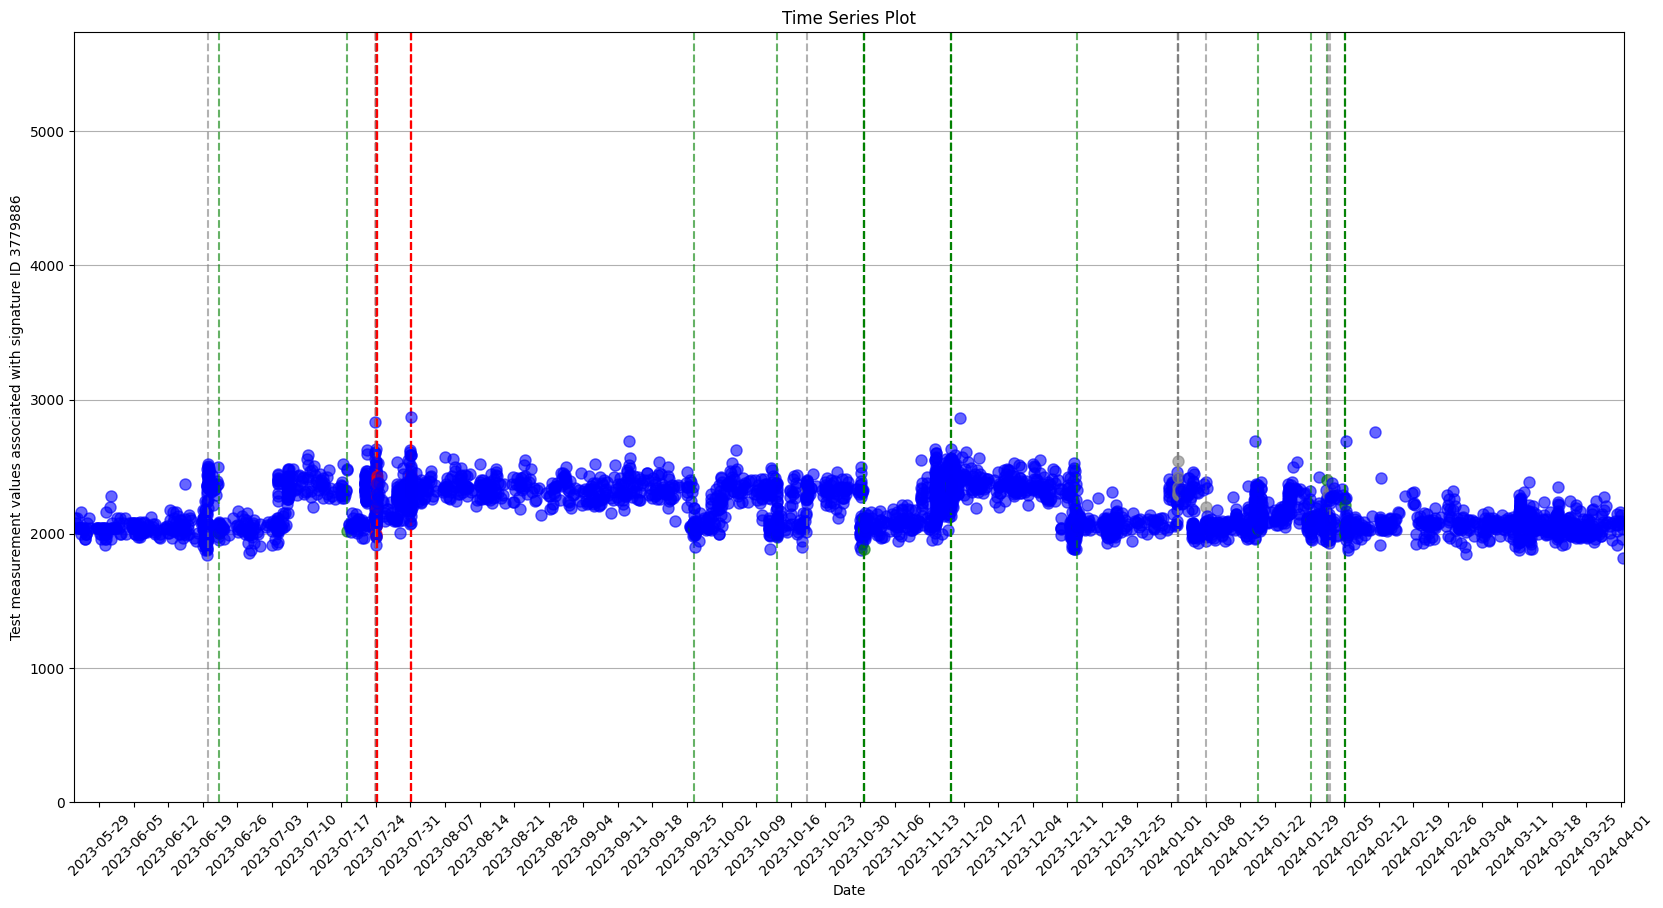

alert_status
TN    98.699937
TP     0.482281
FP     0.482281
SP     0.335500
Name: proportion, dtype: float64
characteristics of signature ID 4722823


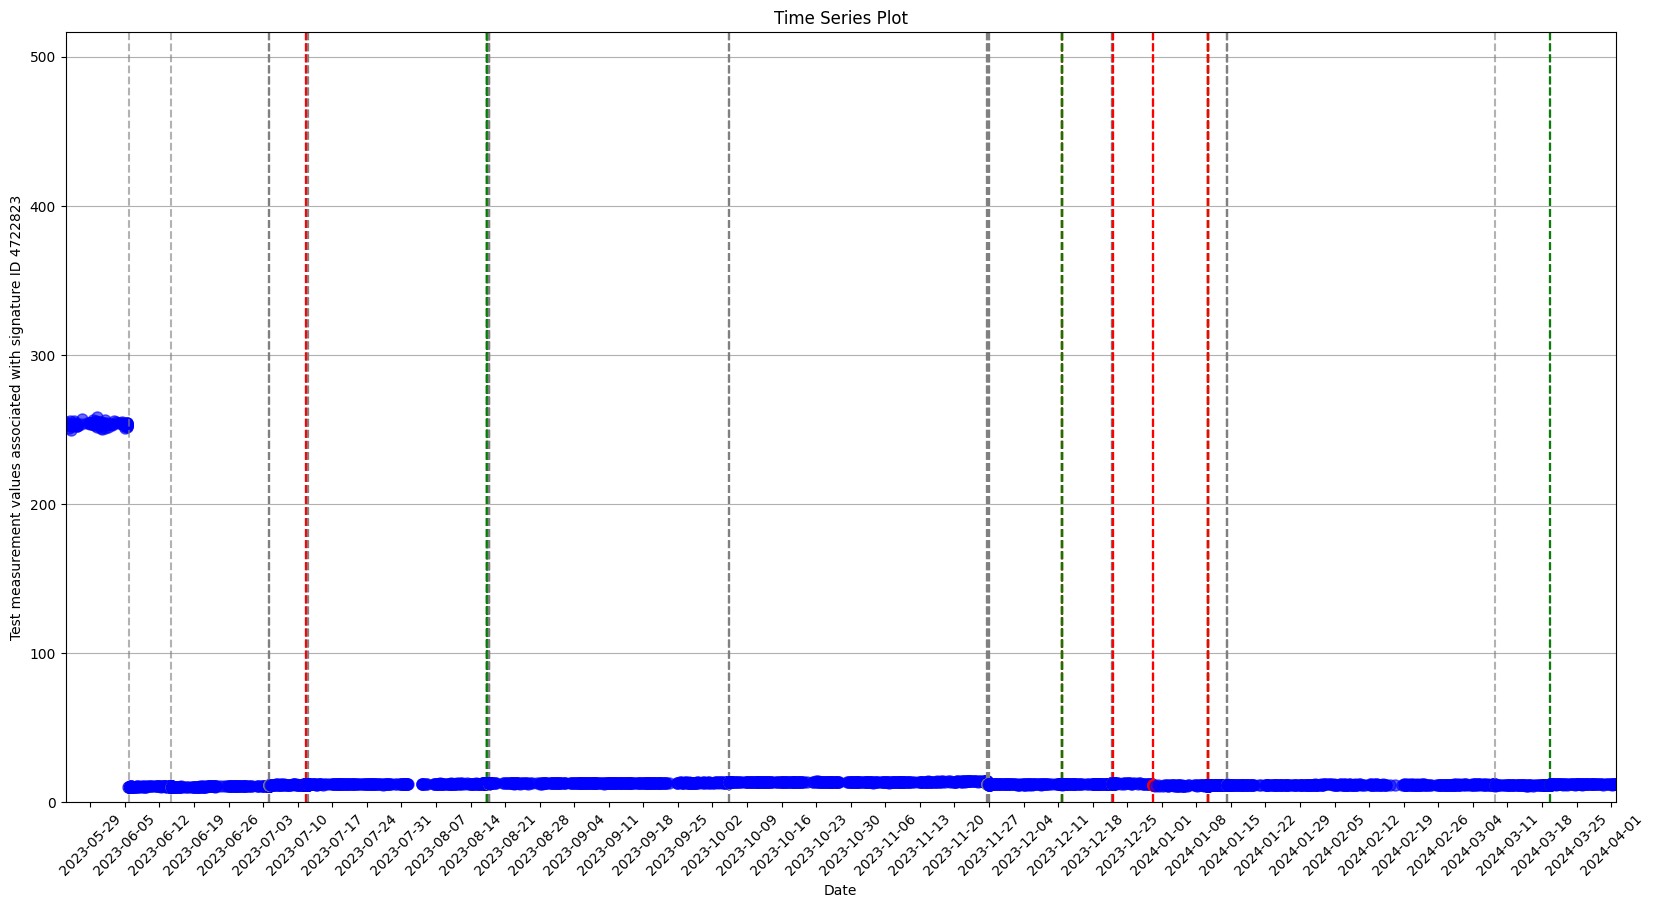

alert_status
TN    95.887446
SP     1.824366
FP     1.144094
TP     1.144094
Name: proportion, dtype: float64


In [102]:
display_sig_characteristics(tp6_df_fp, 3779886)
display_sig_characteristics(speedometer3_df_fp, 4722823)